In [71]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data174891  gene_seq.csv   test_dataset.csv
data174892  mirna_seq.csv  Train.csv


In [72]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [1]:
import pandas as pd
import itertools
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
import joblib

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [2]:
dataset=pd.read_csv('./data/Train.csv')
mirna_seqdf=pd.read_csv('./data/mirna_seq.csv')#(['mirna', 'seq']
gene_seqdf=pd.read_csv('./data/gene_seq.csv')#'label', 'sequence'

In [3]:
dataset.isnull().sum()/len(dataset)*100

gene     0.0
miRNA    0.0
label    0.0
dtype: float64

In [4]:
dataset_mirna=dataset['miRNA']
dataset_gene=dataset['gene']
dataset_label=dataset['label']
gene_index=gene_seqdf['label'].values.tolist()
gene_seq=gene_seqdf['sequence']
mirna_index=mirna_seqdf['mirna'].values.tolist()
mirna_seq=mirna_seqdf['seq']

In [8]:
dataset_label

0          Functional MTI
1          Functional MTI
2      Non-Functional MTI
3          Functional MTI
4      Non-Functional MTI
              ...        
733        Functional MTI
734        Functional MTI
735        Functional MTI
736        Functional MTI
737        Functional MTI
Name: label, Length: 738, dtype: object

In [80]:
gene_seq.head

<bound method NDFrame.head of 0        TGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGCCGG...
1        AGATGCTTTTTTAAATTTAAGAATAAGACACACAAAACTCTATTAA...
2        CCTGCCCGCGAAGTTGCGGACAGTGCGTGAGAAACCAGCACCCCCT...
3        GGGGGACGGGCAGGGTGGGCCTAGGTTTGAGAGCCCTGGGGCTCCA...
4        ATGACCAGGACAATGAAGACTGCATCAATCGTCATAATGTCTATAT...
                               ...                        
16122    CAGGTTTGATGCTGCCAAGTTTGTCATGAGATGGCTCTGTAAGCAT...
16123    TAGCCATAAGTATTGGATAGTTGAATCACAGGAATCCTTTTTGTGA...
16124    AGGCATGGAATAGGTGCTCTGACCTCTGACCCTCTAGCCCAGGGAG...
16125    CTCCTTTTTGATCCTGTCCCTCACCCACCTTCACACACACACACGC...
16126    GGCCAGGTCCAGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGG...
Name: sequence, Length: 16127, dtype: object>

In [81]:
gene_index[0:10]

['A1BG',
 'A1CF',
 'A2BP1',
 'A2LD1',
 'A2M',
 'A2ML1',
 'A4GNT',
 'AAAS',
 'AACS',
 'AADAC']

In [82]:
dataset_label.head

<bound method NDFrame.head of 0          Functional MTI
1          Functional MTI
2      Non-Functional MTI
3          Functional MTI
4      Non-Functional MTI
              ...        
733        Functional MTI
734        Functional MTI
735        Functional MTI
736        Functional MTI
737        Functional MTI
Name: label, Length: 738, dtype: object>

In [83]:
dataset.columns

Index(['gene', 'miRNA', 'label'], dtype='object')

In [5]:
key_set={}
key_set_T={}
for i in itertools.product('UCGA', repeat =3):#itertools.product('BCDEF', repeat = 2):
     # print(i)
     obj=''.join(i)
     # print(obj)
     ky={'{}'.format(obj):0}
     # print(ky)
     key_set.update(ky)
print(type(key_set),key_set)
for i in itertools.product('TCGA', repeat =3):#itertools.product('BCDEF', repeat = 2):
     #print(i)
     obj=''.join(i)
    # print(obj)
     ky={'{}'.format(obj):0}
     key_set_T.update(ky)

<class 'dict'> {'UUU': 0, 'UUC': 0, 'UUG': 0, 'UUA': 0, 'UCU': 0, 'UCC': 0, 'UCG': 0, 'UCA': 0, 'UGU': 0, 'UGC': 0, 'UGG': 0, 'UGA': 0, 'UAU': 0, 'UAC': 0, 'UAG': 0, 'UAA': 0, 'CUU': 0, 'CUC': 0, 'CUG': 0, 'CUA': 0, 'CCU': 0, 'CCC': 0, 'CCG': 0, 'CCA': 0, 'CGU': 0, 'CGC': 0, 'CGG': 0, 'CGA': 0, 'CAU': 0, 'CAC': 0, 'CAG': 0, 'CAA': 0, 'GUU': 0, 'GUC': 0, 'GUG': 0, 'GUA': 0, 'GCU': 0, 'GCC': 0, 'GCG': 0, 'GCA': 0, 'GGU': 0, 'GGC': 0, 'GGG': 0, 'GGA': 0, 'GAU': 0, 'GAC': 0, 'GAG': 0, 'GAA': 0, 'AUU': 0, 'AUC': 0, 'AUG': 0, 'AUA': 0, 'ACU': 0, 'ACC': 0, 'ACG': 0, 'ACA': 0, 'AGU': 0, 'AGC': 0, 'AGG': 0, 'AGA': 0, 'AAU': 0, 'AAC': 0, 'AAG': 0, 'AAA': 0}


In [6]:
def clean_key_set(key_set):
     for i,key in enumerate(key_set):
    #    print(i,key,key_set[key])
       key_set[key]=0   #有疑问初步猜测是将value置为0
     return key_set
# 处理key_set
def return_features(n,seq):
     clean_key_set(key_set)
     key=key_set
     if '\n' in seq:
         seq=seq[0:-1]   #有疑问，需要知道seq的数据形式
     for i in range(n,len(seq)+1-n):
         win=seq[i:i+n]
         #print(win)
         ori=key_set['{}'.format(win)]
         key_set['{}'.format(win)]=ori+1
     return key_set
def return_gene_features(n,seq):
     clean_key_set(key_set_T)
     key=key_set_T
     if '\n' in seq:
         seq=seq[0:-1]  #去掉“\n”
     for i in range(n,len(seq)+1-n):
         win=seq[i:i+n]
         #print(win)
         ori=key_set_T['{}'.format(win)]
         key_set_T['{}'.format(win)]=ori+1
     return key_set_T

In [7]:
def construct_dataset(dataset_mirna,dataset_gene):
     list_mirna_feature=[]
     list_gene_feature=[]
     for i in range(0,len(dataset_mirna)):
         try:
            #  1.选取Train文件中第i个mirna
             mirna=dataset_mirna[i] #dataset=pd.read_csv('./datasets/Train.csv')
            #  2.获得该mirna在RNA序列中的索引
             m_index=mirna_index.index(mirna)   #mirna_index=mirna_seqdf['mirna'].values.tolist()
             #print(m_index)
            #  3.获取该索引值对应的mirnaRNA序列的特征
             mirna_f=return_features(3,mirna_seq[m_index]) 
            #  4.对gene重复以上步骤
             gene=dataset_gene[i]
             g_index=gene_index.index(gene)
             gene_f=return_gene_features(3, gene_seq[g_index])
             #print(gene_f)
            #  5.gene和mirna特征序列复制到新的对象
             mirna_feature=mirna_f.copy()
             gene_feature=gene_f.copy()
            #  6.加到list末尾
             list_mirna_feature.append(mirna_feature)
             list_gene_feature.append(gene_feature)
         except:
             mirna=dataset_mirna[i]
             gene=dataset_gene[i]
             print('error detected',i,mirna,gene)
     lmpd=pd.DataFrame(list_mirna_feature)
     lgpd=pd.DataFrame(list_gene_feature)
    #  print(lgpd)
    #  7.将两个DataFrame拼接
     X=pd.concat([lmpd,lgpd],axis=1)
     return X

In [8]:
#标签换为数字
Y=[]
for i,label in enumerate(dataset_label):
     if label =='Functional MTI':
         Y.append(1)
     else:
         Y.append(0)

In [9]:
X=construct_dataset(dataset_mirna,dataset_gene)

In [14]:
X

UUU  UUC  UUG  UUA  UCU  UCC  UCG  UCA  UGU  UGC  ...  ACG  ACA  AGT  \
0      0    0    1    0    2    0    1    0    1    1  ...    7   52   69   
1      1    0    1    0    0    0    0    1    1    0  ...   21   30   27   
2      1    0    1    0    0    1    0    1    1    1  ...   11   75  109   
3      0    0    1    0    0    0    0    0    1    0  ...    6   35   34   
4      0    0    0    0    1    0    0    0    1    0  ...    2   26   20   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
733    0    0    0    0    1    0    0    0    2    0  ...    1    5    7   
734    0    0    0    0    0    0    0    1    0    0  ...    4   24   23   
735    0    0    1    0    0    0    0    0    0    0  ...    5   26   16   
736    1    0    1    0    0    0    0    0    2    0  ...   12   71   56   
737    0    0    1    0    0    0    0    0    0    0  ...    7    9    6   

     AGC  AGG  AGA  AAT  AAC  AAG  AAA  
0     38   31   69   88   44   66  111  
1     40   48   30   20   24   33   35  
2     36   71   97  123   67  102  172  
3     40   44   56   39   32   63   77  
4     12   19   36   50   19   29   67  
..   ...  ...  ...  ...  ...  ...  ...  
733    2    3    2    8    4    8   11  
734   14   18   26   29   17   28   22  
735   26   21   41   27   25   31   63  
736  102   38   40   30   34   38   32  
737   30   54   21   11   11   25    9  

[738 rows x 128 columns]

In [10]:
# 按照用户设定的比例(0.8)，随机将样本集合划分为训练集 和测试集，并返回划分好的训练集和测试集数据。
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.8, random_state=2)

In [11]:
#将数据「居中」和「标准化」
import numpy as np
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X)
y_train = np.array(Y)

In [38]:
X_train_scaled

array([[-0.46768204, -0.49438054,  0.93525535, ...,  0.36552222,
         0.43405843,  0.34775461],
       [ 1.13766375, -0.49438054,  0.93525535, ..., -0.34342758,
        -0.3993584 , -0.60616824],
       [ 1.13766375, -0.49438054,  0.93525535, ...,  1.1808145 ,
         1.34324043,  1.1134032 ],
       ...,
       [-0.46768204, -0.49438054,  0.93525535, ..., -0.30798009,
        -0.44986851, -0.25472298],
       [ 1.13766375, -0.49438054,  0.93525535, ...,  0.01104732,
        -0.27308312, -0.64382309],
       [-0.46768204, -0.49438054,  0.93525535, ..., -0.80424495,
        -0.60139884, -0.93251026]])

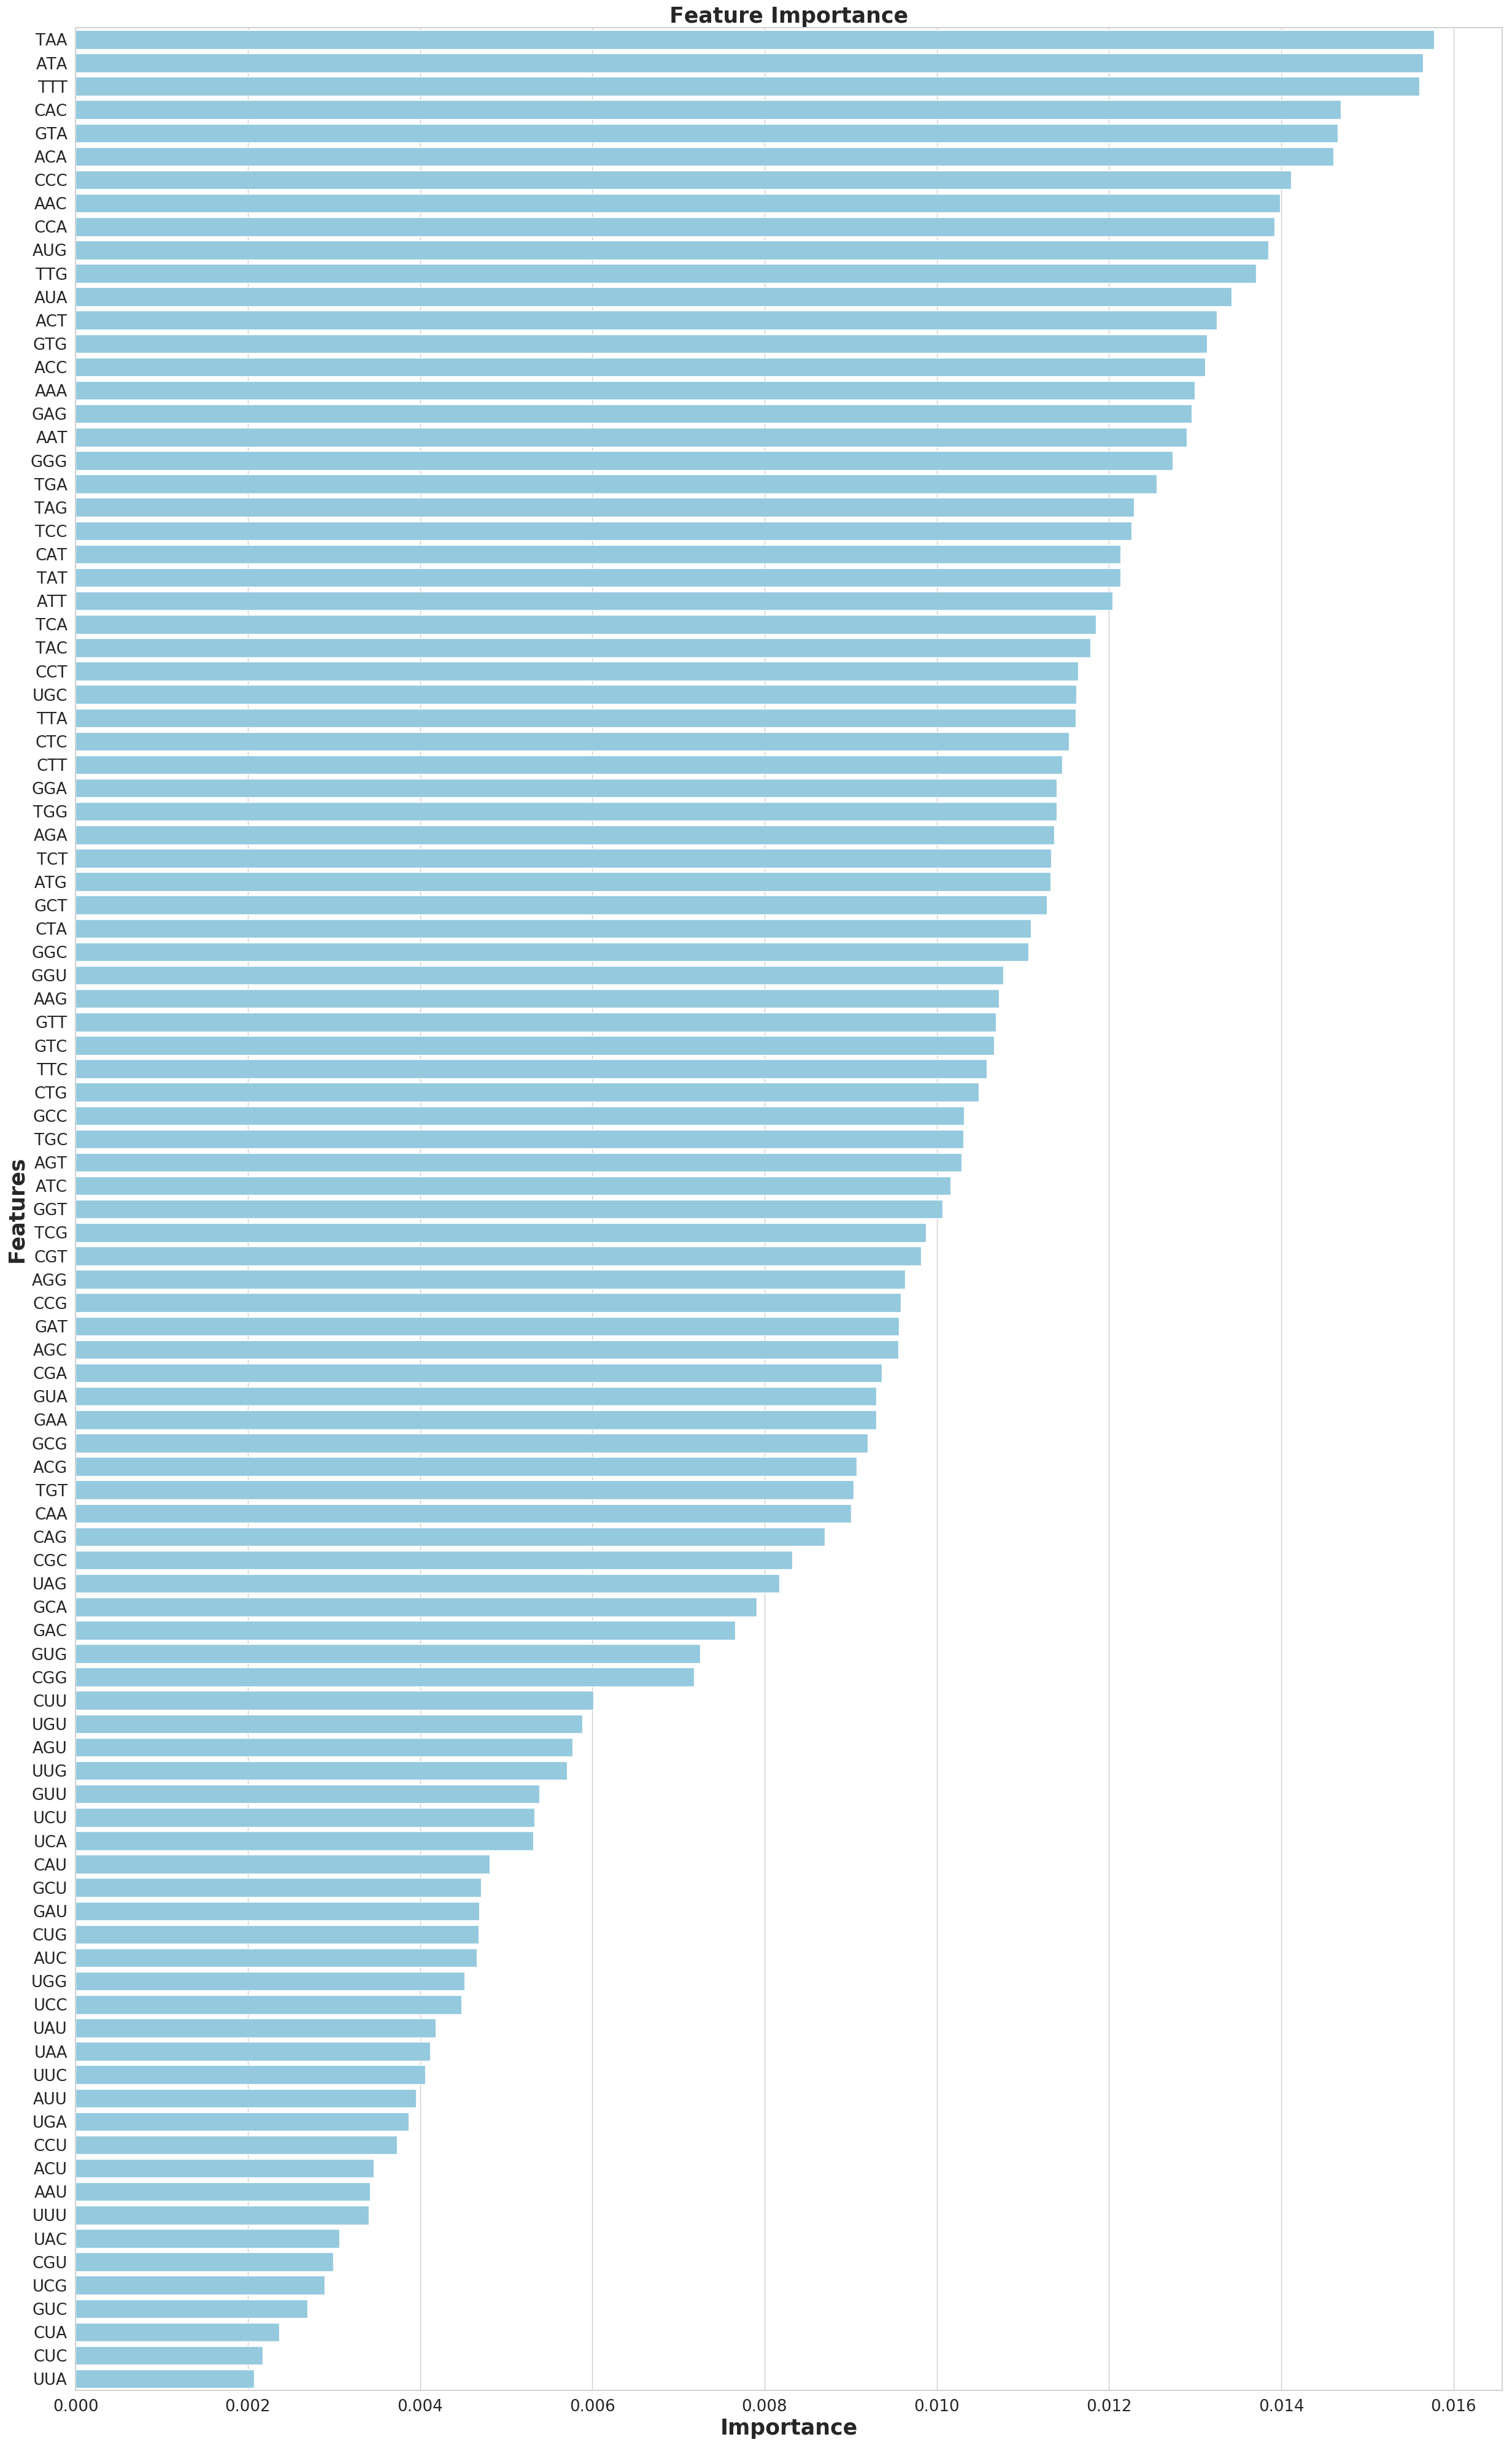

None

Features  Gini-Importance
0        TAA         0.015777
1        ATA         0.015647
2        TTT         0.015606
3        CAC         0.014691
4        GTA         0.014652
..       ...              ...
96       UCG         0.002894
97       GUC         0.002692
98       CUA         0.002366
99       CUC         0.002170
100      UUA         0.002069

[101 rows x 2 columns]

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# 构建基线模型
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)

feats = {}
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,50)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

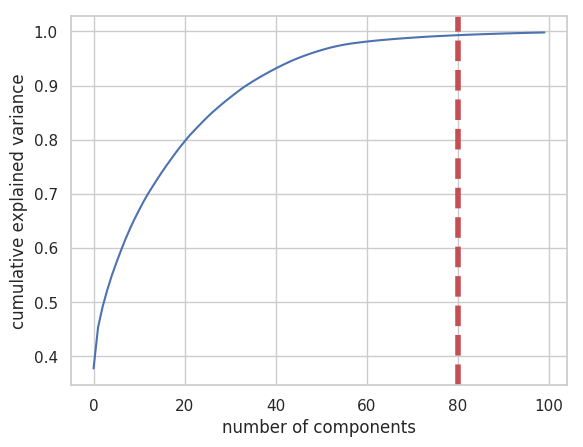

None

Cumulative Variance Ratio  Explained Variance Ratio
0                    0.377710                  0.377710
1                    0.453950                  0.076239
2                    0.491911                  0.037961
3                    0.522261                  0.030351
4                    0.549161                  0.026900
..                        ...                       ...
75                   0.991158                  0.000454
76                   0.991592                  0.000434
77                   0.992006                  0.000413
78                   0.992408                  0.000403
79                   0.992796                  0.000388

[80 rows x 2 columns]

In [40]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=100)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=80, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(80))

In [14]:
pca = PCA(n_components=80)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)

In [15]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
c = np.array(X.columns)
pca_test_df = pd.DataFrame(pca_test.components_, columns=c, index=pca_dims)
pca_test_df.head(40).T

PCA Component 0  PCA Component 1  PCA Component 2  PCA Component 3  \
UUU        -0.001587         0.002903        -0.081843         0.125080   
UUC        -0.000902        -0.003575        -0.142436         0.065834   
UUG         0.000044         0.004173        -0.032063         0.276304   
UUA         0.003921         0.004279         0.002844         0.161916   
UCU         0.000992         0.002785        -0.123462         0.019495   
..               ...              ...              ...              ...   
AGA         0.137564        -0.042541         0.005687        -0.000722   
AAT         0.120626        -0.161114        -0.004828         0.008818   
AAC         0.134456        -0.081195         0.006559         0.000295   
AAG         0.136167        -0.058837         0.000970        -0.001489   
AAA         0.123969        -0.137172         0.001496         0.012490   

     PCA Component 4  PCA Component 5  PCA Component 6  PCA Component 7  \
UUU         0.044929        -0.075888         0.182401        -0.068357   
UUC         0.210408        -0.062896         0.076557         0.079358   
UUG        -0.034915        -0.118274        -0.041646        -0.163860   
UUA         0.043864        -0.075544         0.046263        -0.206564   
UCU         0.193886        -0.075630        -0.164848         0.025926   
..               ...              ...              ...              ...   
AGA        -0.000488        -0.005103        -0.000152         0.005950   
AAT         0.001213        -0.016408        -0.007215         0.006413   
AAC        -0.005752        -0.015457        -0.015663         0.013310   
AAG         0.001437        -0.007486         0.001130        -0.000098   
AAA        -0.001312        -0.016106        -0.009327         0.002412   

     PCA Component 8  PCA Component 9  ...  PCA Component 30  \
UUU        -0.006621         0.068670  ...          0.111538   
UUC        -0.058148        -0.066376  ...          0.107572   
UUG         0.054838         0.120610  ...         -0.162711   
UUA        -0.025980        -0.044829  ...         -0.128831   
UCU        -0.072719        -0.270235  ...         -0.029182   
..               ...              ...  ...               ...   
AGA         0.005016         0.008791  ...          0.042147   
AAT        -0.002642         0.006866  ...          0.015951   
AAC         0.005510         0.004086  ...          0.023994   
AAG         0.003369         0.010394  ...          0.038893   
AAA         0.002994         0.011601  ...          0.029811   

     PCA Component 31  PCA Component 32  PCA Component 33  PCA Component 34  \
UUU          0.050131          0.022664         -0.087270         -0.489778   
UUC          0.038507         -0.005522          0.042589          0.025326   
UUG          0.081684          0.235303         -0.114123          0.197173   
UUA          0.025506         -0.034872          0.180477          0.086233   
UCU         -0.115778          0.135156         -0.137996         -0.196996   
..                ...               ...               ...               ...   
AGA         -0.002441          0.088532          0.095971          0.059223   
AAT         -0.000408         -0.002124         -0.008790          0.004447   
AAC         -0.015879          0.038283          0.038965          0.020667   
AAG         -0.014125          0.098235          0.085613          0.046235   
AAA         -0.021217          0.024977          0.027660          0.016235   

     PCA Component 35  PCA Component 36  PCA Component 37  PCA Component 38  \
UUU          0.036408          0.099398         -0.192030          0.234229   
UUC         -0.166543          0.118376          0.298697         -0.047291   
UUG          0.036608         -0.199707         -0.112899         -0.013532   
UUA          0.099083          0.072712         -0.101788          0.013352   
UCU          0.085073          0.070012          0.072125         -0.172512   
..         

0.7154202147352833 41


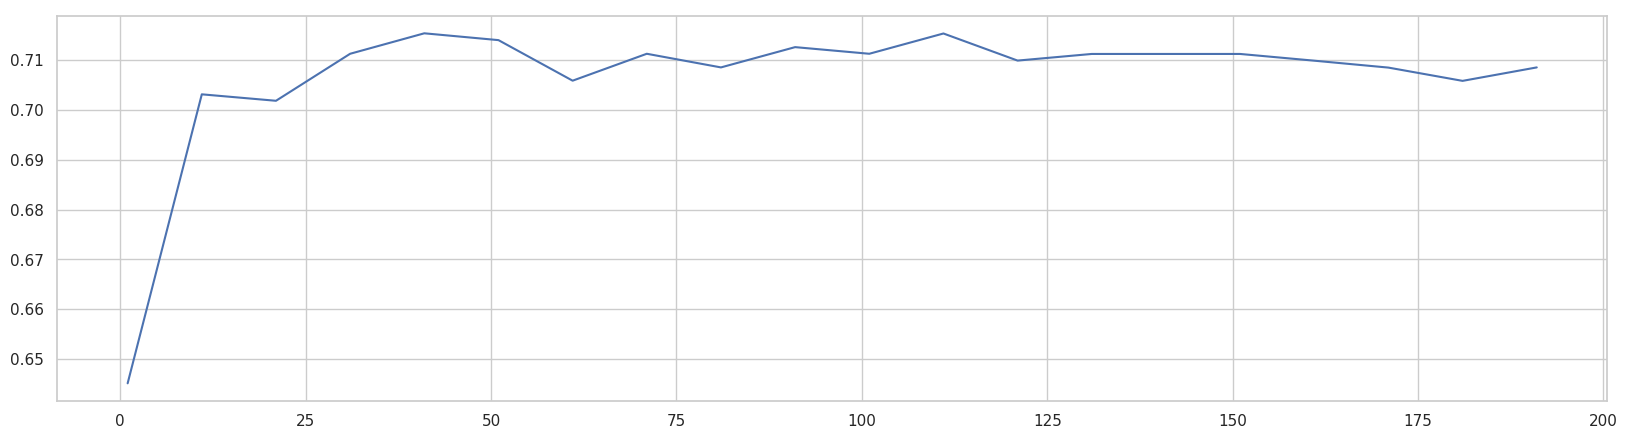

In [16]:
# (1)对n_estimators参数采用学习曲线查找最优值
scorel = []
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1,
                                n_jobs=-1,
                                random_state=90)
    score = cross_val_score(rfc,X_train_scaled_pca,Y,cv=10).mean()
    scorel.append(score)

print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

0.7154202147352833 38


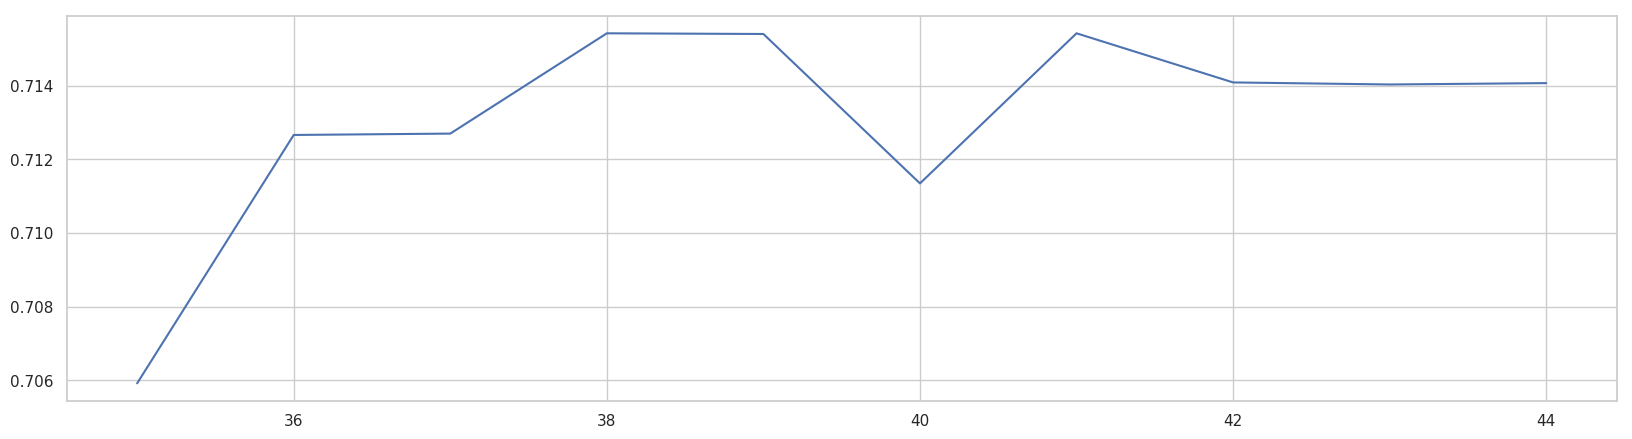

In [27]:
scorel = []
for i in range(35,45):
    rfc = RandomForestClassifier(n_estimators=i,
                                n_jobs=-1,
                                random_state=90)
    score = cross_val_score(rfc,X_train_scaled_pca,Y,cv=10).mean()
    scorel.append(score)

print(max(scorel),([*range(35,45)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(35,45),scorel)
plt.show()

In [18]:
# (2)对max_depth参数采用网格查找最优值
param_grid = {'max_depth':np.arange(1, 30, 1)}
rfc = RandomForestClassifier(n_estimators=38,
                            n_jobs=-1,
                            random_state=90)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X_train_scaled_pca,Y)
bp = GS.best_params_
print('best_params_',bp)
bs = GS.best_score_
print('best_score_',bs)

best_params_ {'max_depth': 7}
best_score_ 0.724824139207701


In [22]:
# (3)对min_samples_leaf参数采用网格查找最优值
param_grid = {'min_samples_leaf':np.arange(1, 1+100, 1)}
rfc = RandomForestClassifier(n_estimators=38,
                            n_jobs=-1,
                            random_state=90,
                            max_depth=7)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X_train_scaled_pca,Y)
bp = GS.best_params_
print('best_params_',bp)
bs = GS.best_score_
print('best_score_',bs)

best_params_ {'min_samples_leaf': 1}
best_score_ 0.724824139207701


In [25]:
# (3)对max_features参数采用网格查找最优值
param_grid = {'min_samples_leaf':np.arange(1, 11, 1)}
rfc = RandomForestClassifier(n_estimators=38,
                            n_jobs=-1,
                            random_state=90,
                            max_depth=7)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X_train_scaled_pca,Y)
bp = GS.best_params_
print('best_params_',bp)
bs = GS.best_score_
print('best_score_',bs)

best_params_ {'min_samples_leaf': 1}
best_score_ 0.724824139207701


In [26]:
# (4)尝试调整Criterion
param_grid = {'criterion':['gini', 'entropy']}

rfc = RandomForestClassifier(n_estimators=38,
                            n_jobs=-1,
                            random_state=90,
                            max_depth=7)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X_train_scaled_pca,Y)
bp = GS.best_params_
print('best_params_',bp)
bs = GS.best_score_
print('best_score_',bs)

best_params_ {'criterion': 'gini'}
best_score_ 0.724824139207701


In [29]:
#将未调整的模型与调参后的模型进行对比
def train():

   rfc = RandomForestClassifier(n_estimators=38,
                                 n_jobs=-1,
                                 random_state=90,
                                 max_depth=7)
   rfc.fit(X_train_scaled_pca,y_train)

   # 10折交叉验证评估分数
   # score_pre = cross_val_score(clf,X,Y,cv=10).mean()
   # print('score_pre',score_pre)
   score_pre = cross_val_score(rfc,X_train_scaled_pca,Y,cv=10).mean()
   print('调整后：score_pre',score_pre)
   # acc = metrics.accuracy_score(y_test,y_p)
   # print('RF_ACC',acc)
   # y_pb=clf.predict_proba(X_test)
   # print(y_pb)
   # f1score=metrics.f1_score(y_test, y_p)
   # print('RF_F1',f1score)
   # f1score=metrics.f1_score(y_test, y_p1)
   # print('调整后：RF_F1',f1score)
   # 马修斯相关系数（衡量二元分类的质量）
   # MCC=metrics.matthews_corrcoef(y_test, y_p)
   # print('MCC',MCC)
   # MCC=metrics.matthews_corrcoef(y_test, y_p1)
   # print('调整后：MCC',MCC)
train()

调整后：score_pre 0.724824139207701


In [30]:
#最终模型
clf_final = RandomForestClassifier(n_estimators=38,
                                 n_jobs=-1,
                                 random_state=90,
                                 max_depth=7)
clf_final.fit(X_train_scaled_pca,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=38, n_jobs=-1,
                       oob_score=False, random_state=90, verbose=0,
                       warm_start=False)

In [31]:
#存储模型与重新调用

joblib.dump(clf_final, "./data/train_model.m") #存储
clf_final = joblib.load("./data/train_model.m") #调用

In [32]:
#加载测试数据
#test_filenames = os.listdir("./datasets")
df_predict=pd.read_csv('./data/test_dataset.csv')

In [33]:
predict_mirna=df_predict['miRNA']
predict_gene=df_predict['gene']

In [ ]:
X_predict=construct_dataset(predict_mirna,predict_gene)

In [35]:
X_predict=construct_dataset(predict_mirna,predict_gene)

ss = StandardScaler()
X_predict_scaled = ss.fit_transform(X_predict)

pca = PCA(n_components=80)
pca.fit(X_predict_scaled)
X_predict_scaled_pca = pca.transform(X_predict_scaled)

final_result=clf_final.predict(X_predict_scaled_pca)

In [36]:
print(final_result)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]


In [37]:
df_predict['results']=final_result
df_predict.to_csv('submission.csv',index=None)